In [ ]:
#pip install git+https://github.com/tensorflow/docs

In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from os import path
from glob import glob
from datetime import date


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from utils import * 
today=date.today().strftime("%Y%m%d")

seed=38

# Load matplotlib inline extension
%matplotlib inline

In [2]:
files = glob('/data/elekin/data/results/fmri/preproc/cbl/*/cbl_extracted_ts_{}.csv'.format(today))
data = []
for file in files:
    df = pd.read_csv(file, header=None)
    data.append(df.values)
features = np.array(data)
features.shape

(105, 158, 28)

In [3]:
levels = pd.read_csv('/data/elekin/data/results/fmri/preproc/cbl/cbl_levels_{}.csv'.format(today),index_col=0)
levels.sample(5)

,Level,Level3
T023,18.0,13.0
T018,5.0,12.0
C084,0.0,11.0
C049,0.0,11.0
C257,0.0,11.0


In [6]:
labels = (levels.Level > 0).astype(np.int16)
labels.sample(5)

C113    0
T069    1
C132    0
C503    0
C103    0
Name: Level, dtype: int16

In [14]:
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.33)

In [12]:
def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, min_delta=0.001),
      ]

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(X_train, y_train, batch_size=None, use_multiprocessing=True, 
                        validation_data=(X_test,y_test), epochs=max_epochs, callbacks=get_callbacks(name),
                        verbose=1)
    return history

## Recurrent Neural Network LSTM

Many models train better if you gradually reduce the learning rate during training. 
Use optimizers.schedules to reduce the learning rate over time:

In [9]:
STEPS_PER_EPOCH = 1
FEATURES = features.shape[1]
CHANNELS = features.shape[2]

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  1e-6,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [10]:
size_histories = {}

In [15]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, activation=tf.nn.tanh,input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
size_histories['lstm/tiny'] = compile_and_fit(lstm, "lstm/tiny", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24)                5088      
                                                                 
 dense (Dense)               (None, 16)                400       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
3/3 [==============================] - 1s 144ms/step - loss: 0.6933 - accuracy: 0.4429 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 2/10000
3/3 [========================

Epoch 52/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6933 - accuracy: 0.4429 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 53/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6933 - accuracy: 0.4429 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 54/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6933 - accuracy: 0.4429 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 55/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6933 - accuracy: 0.4429 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 56/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6933 - accuracy: 0.4429 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 57/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6932 - accuracy: 0.4429 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 58/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6932 - accuracy: 0.4429 - val_loss: 0.6933 - val_accuracy: 0.4286

In [16]:
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
small = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, activation=tf.nn.tanh,input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.LSTM(256, activation=tf.nn.tanh),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
size_histories['lstm/small'] = compile_and_fit(small, "lstm/small", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 158, 256)          291840    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 16)                4112      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 821,409
Trainable params: 821,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
3/3 [==============================]

Epoch 51/10000
3/3 [==============================] - 0s 25ms/step - loss: 0.6935 - accuracy: 0.4714 - val_loss: 0.6928 - val_accuracy: 0.6286
Epoch 52/10000
3/3 [==============================] - 0s 26ms/step - loss: 0.6935 - accuracy: 0.4714 - val_loss: 0.6928 - val_accuracy: 0.6286
Epoch 53/10000
3/3 [==============================] - 0s 24ms/step - loss: 0.6935 - accuracy: 0.4714 - val_loss: 0.6928 - val_accuracy: 0.6286
Epoch 54/10000
3/3 [==============================] - 0s 24ms/step - loss: 0.6935 - accuracy: 0.4714 - val_loss: 0.6928 - val_accuracy: 0.6000
Epoch 55/10000
3/3 [==============================] - 0s 24ms/step - loss: 0.6935 - accuracy: 0.4714 - val_loss: 0.6928 - val_accuracy: 0.6000
Epoch 56/10000
3/3 [==============================] - 0s 24ms/step - loss: 0.6935 - accuracy: 0.4714 - val_loss: 0.6928 - val_accuracy: 0.6000
Epoch 57/10000
3/3 [==============================] - 0s 24ms/step - loss: 0.6935 - accuracy: 0.4714 - val_loss: 0.6928 - val_accuracy: 0.6000

(0.0, 2.15)

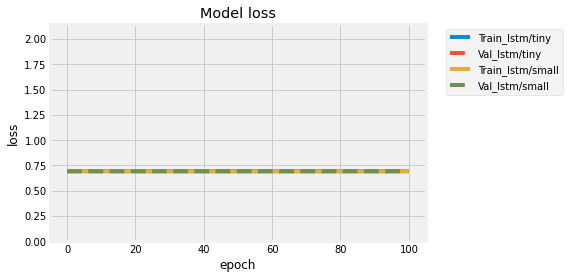

In [19]:
plot_report(size_histories, 'loss')
plt.ylim([0., 2.15])

(0.3, 1.02)

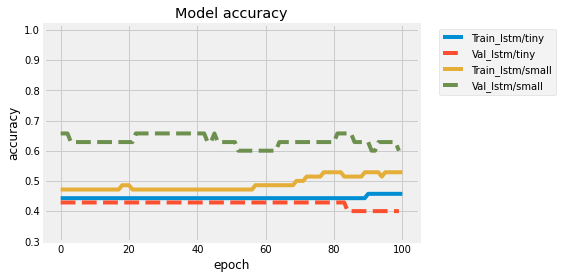

In [25]:
plot_report(size_histories)
plt.ylim([0.3, 1.02])

## Bidirectional

In [23]:
regularizer_histories = {}
#regularizer_histories['tiny'] = size_histories['lstm/tiny']

In [24]:
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=tf.nn.relu),input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation=tf.nn.relu)),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
regularizer_histories['bi-tiny'] = compile_and_fit(lstm, "lstm/regularizers/bi-tiny", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 158, 512)         583680    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,166,945
Trainable params: 2,166,945
Non-

Epoch 43/10000
3/3 [==============================] - 1s 510ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 44/10000
3/3 [==============================] - 2s 533ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 45/10000
3/3 [==============================] - 2s 539ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 46/10000
3/3 [==============================] - 1s 510ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 47/10000
3/3 [==============================] - 1s 515ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 48/10000
3/3 [==============================] - 1s 514ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 49/10000
3/3 [==============================] - 1s 516ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy:

KeyboardInterrupt: 

### Regularization

In [ ]:
# Drop out
dr=0.2
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, activation=tf.nn.tanh,input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.LSTM(128, activation=tf.nn.tanh),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)],)
regularizer_histories['drop-tiny'] = compile_and_fit(lstm, "lstm/regularizers/drp-tiny", optimizer=None, max_epochs=10000)

In [ ]:
# Drop out
dr=0.25
lr=1e-6
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, activation=tf.nn.tanh, kernel_regularizer=regularizers.l2(lr), input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(lr)),
    tf.keras.layers.Dense(8, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(lr)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l2(lr))],)
regularizer_histories['kernel'] = compile_and_fit(lstm, "lstm/regularizers/kernel-reg", optimizer=None, max_epochs=10000)

In [ ]:
plot_report(regularizer_histories,'loss')
plt.ylim([0., 2.15])

In [ ]:
plot_report(regularizer_histories)
plt.ylim([0.3, 1.02])